In [34]:
import os
import sys
from chordUtils import json2lab, MBIDAwareKFold
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001
    return data

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = preprocessing.normalize(imputeZeros(chromas), norm='l1')
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def normalizeByRootTo11d(chromas) :
    c = imputeZeros(chromas)
    d = c[:,0]
    c = c[:,1:]/d[:, np.newaxis]
    return c

def logNormalizeByRootTo11d(chromas) :
    c = normalizeByRootTo11d(chromas)
    return np.log(c)

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='diag',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [2]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [3]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(mbids, kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = MBIDAwareKFold(n_splits = nfolds, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(mbids):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(mbids, kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(mbids, kinds, chromas, ncomp, nfolds=5, debug=debug)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

In [4]:
symcomponents = np.array([1,15,20,40])
chromaFile = '../chroma275.npz'

# No normalization

maj 77.4039517014 %
min 67.6766875545 %
dom 53.0242360379 %
hdim7 62.8164556962 %
dim 67.290886392 %
total:  63.7083152358 %
maj BIC:  196103.115397  N:  18
min BIC:  153862.48352  N:  12
dom BIC:  359596.866677  N:  20
hdim7 BIC:  19005.0856283  N:  5
dim BIC:  23294.4585733  N:  6


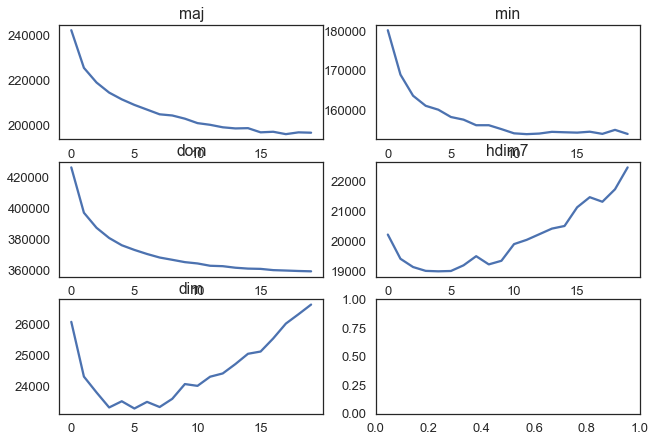

[ 18.  12.  20.   5.   6.]


In [5]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

#violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas, max_components=20)
print n_components


Time span:  94.648045063
[ 63.84587126  69.51656423  70.0948296   73.05891118]
[ 63.36709942  64.72188558  64.24848529  65.07597365]


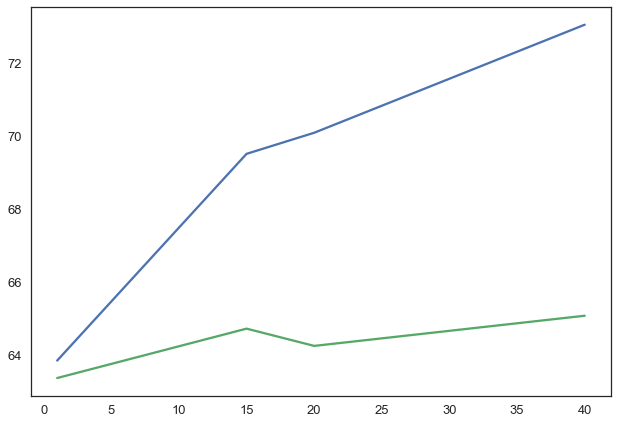

In [6]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

start = time.time()
rawTrains, rawTests = trainTestSymmetricalModels(mbids, kinds, chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print rawTrains
print rawTests
plt.plot(symcomponents, rawTrains)
plt.plot(symcomponents, rawTests)
plt.show()

maj 74.5225027442 %
min 70.5481081939 %
dom 61.215314366 %
hdim7 61.6297468354 %
dim 67.1660424469 %
total:  67.1701816193 %
maj BIC:  364995.737599  N:  17
min BIC:  265362.576208  N:  10
dom BIC:  594424.280808  N:  16
hdim7 BIC:  28677.1483448  N:  4
dim BIC:  34782.916749  N:  4


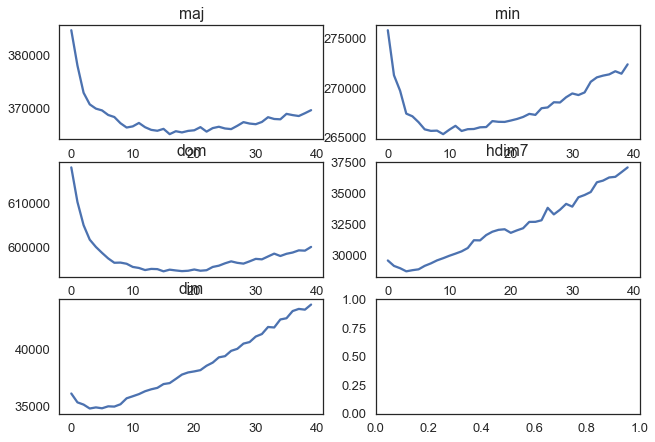

[ 17.  10.  16.   4.   4.]


In [7]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
#violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
score(model, kinds, sxChromas, debug=True)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components



# Log-ratio transform

Time span:  303.682104111
[ 67.30063924  70.51645503  71.42218983  73.52055574]
[ 66.64921976  66.03995011  66.28177043  66.27676851]


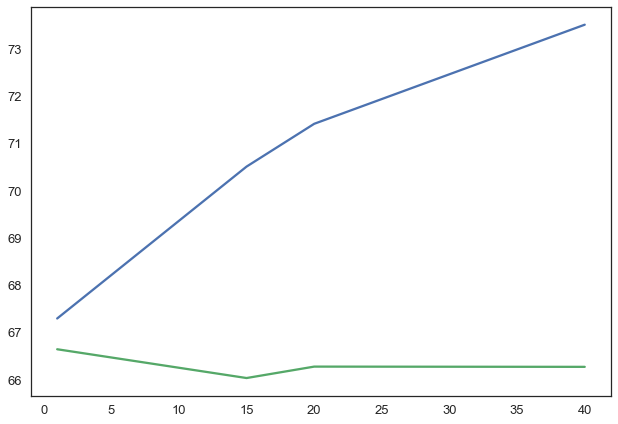

In [8]:
# Compositional data model
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
start = time.time()
sxTrains, sxTests = trainTestSymmetricalModels(mbids, kinds, sxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print sxTrains
print sxTests
plt.plot(symcomponents, sxTrains)
plt.plot(symcomponents, sxTests)
plt.show()




# Just L1

maj 77.31064764 %
min 67.4307924169 %
dom 53.3614330875 %
hdim7 61.6297468354 %
dim 67.8526841448 %
total:  63.7758795425 %
Time span:  323.358041048
[ 63.97600322  68.9935092   70.00343424  72.47055157]
[ 63.44861532  64.13617852  64.44130439  64.4624887 ]


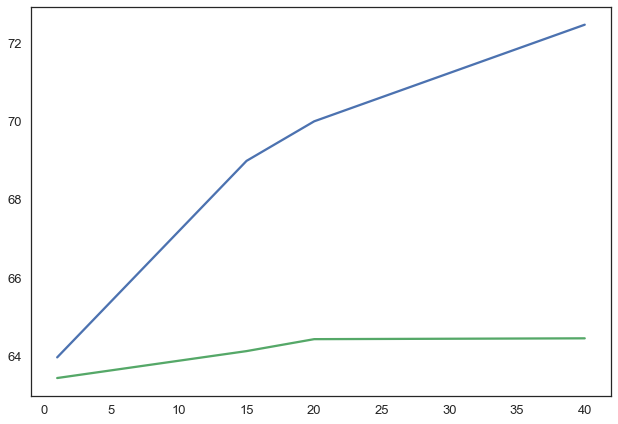

In [9]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1Chromas = normalize(chromas)
#violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1Chromas)
#print n_components
start = time.time()
l1Trains, l1Tests = trainTestSymmetricalModels(mbids, kinds, l1Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1Trains
print l1Tests
plt.plot(symcomponents, l1Trains)
plt.plot(symcomponents, l1Tests)
plt.show()



# L1-log

maj 74.2041712404 %
min 69.9849290077 %
dom 60.2037232174 %
hdim7 60.0474683544 %
dim 67.1660424469 %
total:  66.4671910944 %
Time span:  603.148250818
[ 66.53938788  70.13572213  71.0476638   73.29002631]
[ 65.81808549  65.45603207  65.28746237  65.30252166]


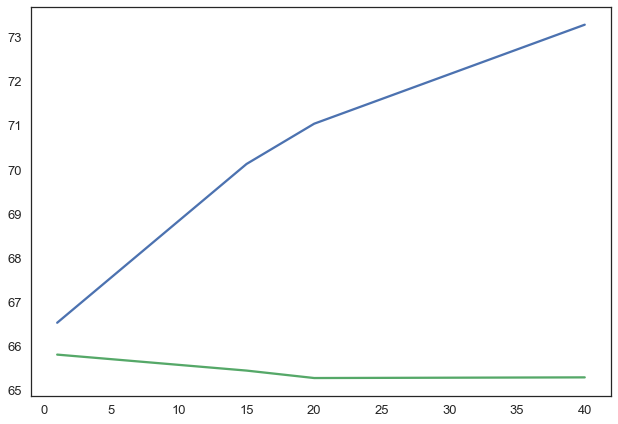

In [10]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1logChromas = logNormalize(chromas)
#violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1logChromas)
#print n_components
start = time.time()
l1logTrains, l1logTests = trainTestSymmetricalModels(mbids, kinds, l1logChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1logTrains
print l1logTests
plt.plot(symcomponents, l1logTrains)
plt.plot(symcomponents, l1logTests)
plt.show()


# L2

maj 77.7661909989 %
min 68.0257000079 %
dom 52.377941693 %
hdim7 62.3417721519 %
dim 67.8526841448 %
total:  63.5940993839 %
Time span:  518.320538998
[ 63.70643861  68.91822682  69.56462949  72.17711644]
[ 63.30510699  64.35175063  64.47971313  64.14721253]


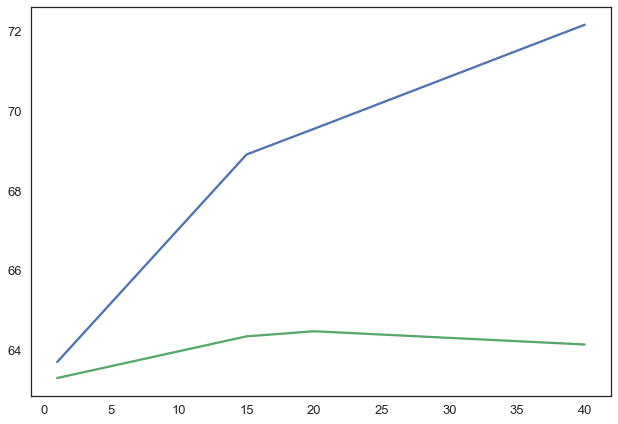

In [11]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l2Chromas = normalize(chromas, norm='l2')
#violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas, debug=True)
#model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
#score(model, kinds, l2Chromas)
#n_components = findOptimalNComponentsByBIC(l2Chromas)
#print n_components
start = time.time()
l2Trains, l2Tests = trainTestSymmetricalModels(mbids, kinds, l2Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l2Trains
print l2Tests
plt.plot(symcomponents, l2Trains)
plt.plot(symcomponents, l2Tests)
plt.show()



# Lmax

maj 78.17233809 %
min 67.6290949473 %
dom 49.2272567615 %
hdim7 61.9462025316 %
dim 66.9163545568 %
total:  62.1575535286 %
Time span:  553.044014931
[ 62.26399186  67.36845396  68.15789204  70.20369132]
[ 61.90252244  64.81115866  65.03210178  65.71416265]


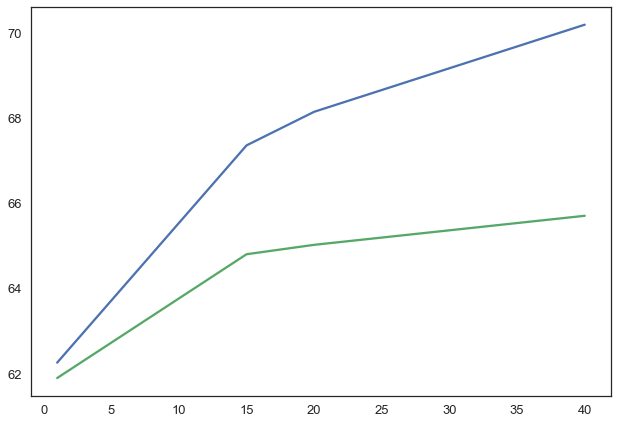

In [12]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

maxChromas = normalize(chromas, norm='max')
#violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas, debug=True)
#model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
#score(model, kinds, maxChromas)
#n_components = findOptimalNComponentsByBIC(maxChromas)
#print n_components
start = time.time()
maxTrains, maxTests = trainTestSymmetricalModels(mbids, kinds, maxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print maxTrains
print maxTests
plt.plot(symcomponents, maxTrains)
plt.plot(symcomponents, maxTests)
plt.show()

# Divide by root

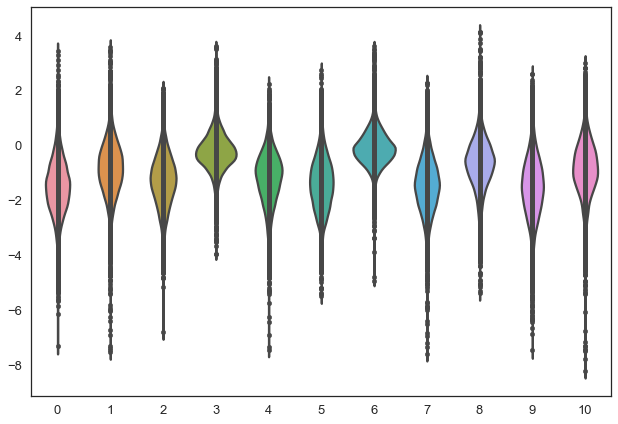

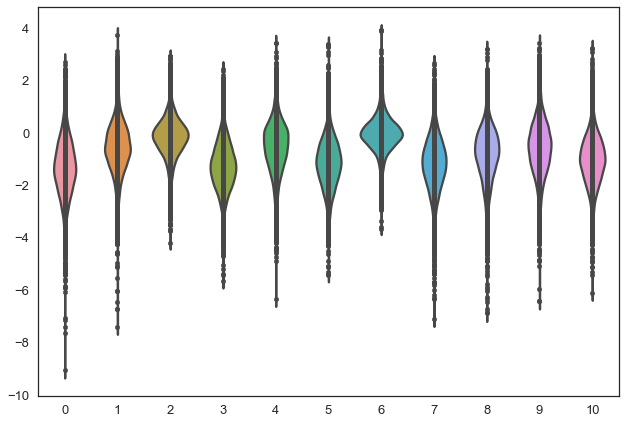

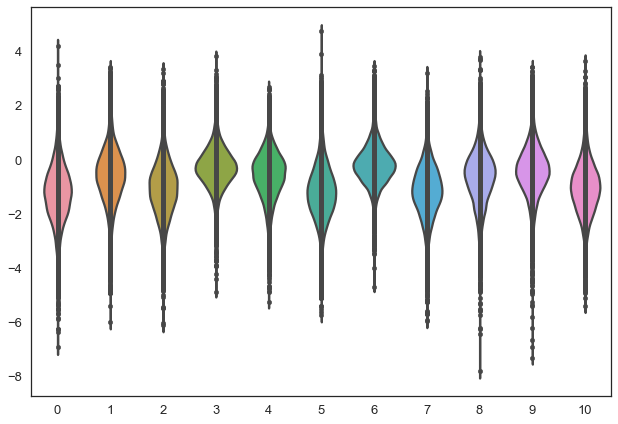

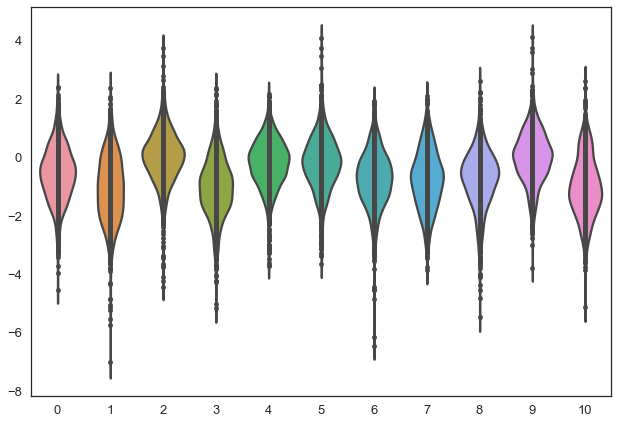

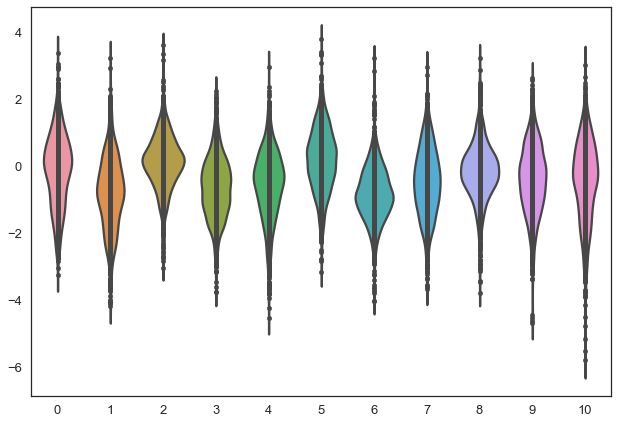

maj 66.531284303 %
min 61.9735067819 %
dom 47.7309448542 %
hdim7 46.4398734177 %
dim 62.0474406991 %
total:  56.4724997185 %
Time span:  81.6471180916
[ 56.62132346  69.30213326  70.16355386  72.3048238 ]
[ 56.34290303  65.57020069  65.86014216  65.77097895]


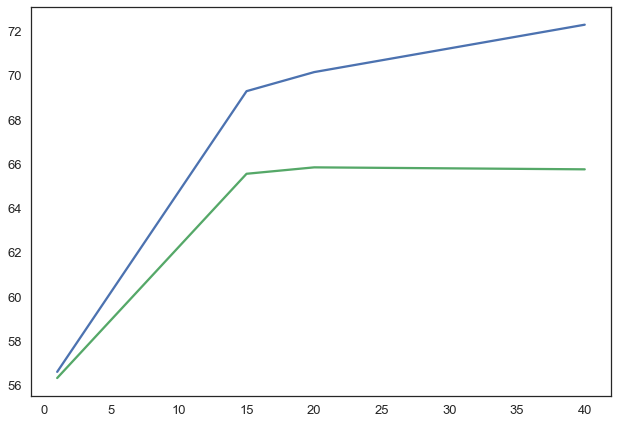

In [36]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

rootChromas = logNormalizeByRootTo11d(chromas)
violinPlots11D(kinds, rootChromas)
model = fitConstModel(kinds, rootChromas, [1,1,1,1,1])
score(model, kinds, rootChromas, debug=True)
#model = fitConstModel(kinds, rootChromas, [2,6,1,1,1])
#score(model, kinds, rootChromas)
#n_components = findOptimalNComponentsByBIC(rootChromas)
#print n_components
start = time.time()
rootTrains, rootTests = trainTestSymmetricalModels(mbids, kinds, rootChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print rootTrains
print rootTests
plt.plot(symcomponents, rootTrains)
plt.plot(symcomponents, rootTests)
plt.show()

In [37]:
symcomponents

array([ 1, 15, 20, 40])

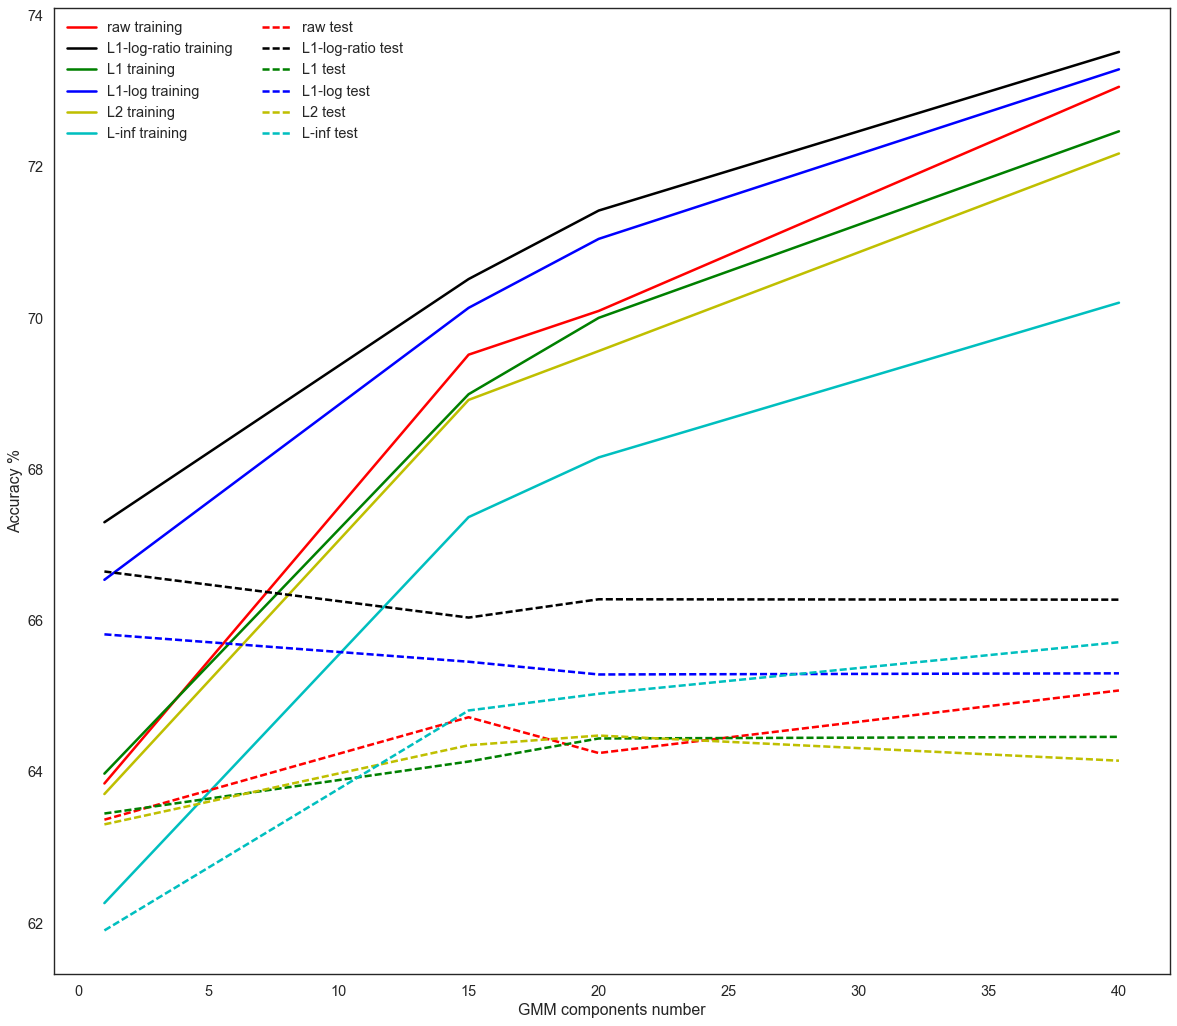

Norm / N of components,1,15,20,40
Raw,63.85,69.52,70.09,73.06
L1-log-ratio,67.3,70.52,71.42,73.52
L1,63.98,68.99,70.0,72.47
L1-log,66.54,70.14,71.05,73.29
L2,63.71,68.92,69.56,72.18
L-inf,62.26,67.37,68.16,70.2


Norm / N of components,1,15,20,40
Raw,63.37,64.72,64.25,65.08
L1-log-ratio,66.65,66.04,66.28,66.28
L1 test,63.45,64.14,64.44,64.46
L1-log,65.82,65.46,65.29,65.3
L2 test,63.31,64.35,64.48,64.15
L-inf test,61.9,64.81,65.03,65.71


In [13]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
line, = plt.plot(symcomponents, rawTrains, 'r-')
line.set_label('raw training')
line, = plt.plot(symcomponents, sxTrains, 'k-')
line.set_label('L1-log-ratio training')
line, = plt.plot(symcomponents, l1Trains, 'g-')
line.set_label('L1 training')
line, = plt.plot(symcomponents, l1logTrains, 'b-')
line.set_label('L1-log training')
line, = plt.plot(symcomponents, l2Trains, 'y-')
line.set_label('L2 training')
line, = plt.plot(symcomponents, maxTrains, 'c-')
line.set_label('L-inf training')

line, = plt.plot(symcomponents, rawTests, 'r--')
line.set_label('raw test')
line, = plt.plot(symcomponents, sxTests, 'k--')
line.set_label('L1-log-ratio test')
line, = plt.plot(symcomponents, l1Tests, 'g--')
line.set_label('L1 test')
line, = plt.plot(symcomponents, l1logTests, 'b--')
line.set_label('L1-log test')
line, = plt.plot(symcomponents, l2Tests, 'y--')
line.set_label('L2 test')
line, = plt.plot(symcomponents, maxTests, 'c--')
line.set_label('L-inf test')

plt.xlabel('GMM components number')
plt.ylabel('Accuracy %')
plt.legend(ncol=2)
plt.show()
from IPython.display import HTML, display
def line2HTML(title, data):
    return '<tr><td>' + title + '</td><td>{}</td></tr>'.format(
        '</td><td>'.join(str(round(x,2)) for x in data))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTrains)
body = body + line2HTML('L1-log-ratio', sxTrains)
body = body + line2HTML('L1', l1Trains)
body = body + line2HTML('L1-log', l1logTrains)
body = body + line2HTML('L2', l2Trains)
body = body + line2HTML('L-inf', maxTrains)
display(HTML('<h3>Training Accuracy %</h3><table>' + header + body + '</table>'))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTests)
body = body + line2HTML('L1-log-ratio', sxTests)
body = body + line2HTML('L1 test', l1Tests)
body = body + line2HTML('L1-log', l1logTests)
body = body + line2HTML('L2 test', l2Tests)
body = body + line2HTML('L-inf test', maxTests)
display(HTML('<h3>Test Accuracy %</h3><table>' + header + body + '</table>'))